# Data statistics

In [1]:
#Numpy
import numpy as np
#Scipy
from scipy import special as scsp
from scipy import stats
from numpy import random as rdm
#Pyplot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#Multi-CPU job
from joblib import Parallel, delayed
import multiprocessing as mpg
#Time
import time
#Json
import json
#Os for file management
import os.path

#Home made functions
import Utilities #Does not work....

RERUN = False #To rerun all computations (False will load from file if they exist)
NCORES_MAX = 4 #Maximal number of cores in use
extension = '.png' #fig file extension
DIR  = 'D:/pdm_data/' #On desktop
#DIR  = 'C:/Users/Antoine/Documents/Etudes/Master CSE/pdm/data/' #On laptop
CASE = 'Bentheimer1000'

In [2]:
#Skew-normal PDF
def p_skew(v,sample) :
    alpha = sample['alpha']
    mu    = sample['mu']
    sigma = sample['sigma']
    p = 1/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-(v-mu)**2/(2.0*sigma**2))*scsp.erfc(-alpha*(v-mu)/np.sqrt(2.0*sigma**2))
    return p

def Save_data(MP_dict, filename) :
    #Copy data into non np array dict for json formating
    No_np = {}
    for key in MP_dict : No_np[key] = [v for v in MP_dict[key]]
    with open(filename, 'w') as outfile:  
        json.dump(No_np, outfile)
    
def Load_data(filename) :
    MP_dict = {}
    with open(filename, 'r') as outfile:  
        MP_dict = json.load(outfile)
    #Converting arrays in np array
    for key in MP_dict : MP_dict[key] = np.array(MP_dict[key])
    return MP_dict

def Extract_param (fname, param) :
    p_dict = {}
    for p_ in param :
        k  = 0
        for i in range(len(DIR),len(fname)) :
            if fname[i:i+len(p_)] == p_ :
                k = i+len(p_)
                break
        v_ = ''
        while (fname[k] != '_' and fname[k:k+2] != '.d') :
            v_ += fname[k]
            k  += 1
        p_dict[p_] = float(v_)
    return p_dict

def time_step_analysis(t_ssl,key) :
    dt         = [t1-t0 for (t1,t0) in zip(t_ssl[1:],t_ssl[:-1]) if t1-t0 > 0]
    dt_hist    = Extract_pdf(dt,50)
    dtDNS_mean = np.mean(dt)
    dtDNS_std  = np.std(dt)
    return (key, dt_hist, dtDNS_mean, dtDNS_std)
    
def parallel_time_step_analysis(t_dict) :
    dt_hist        = {}
    dtDNS_mean     = {}
    dtDNS_std      = {}
    results  = Parallel(n_jobs=NCORES_MAX)(delayed(time_step_analysis)(t_dict[key],key) for key in KEYS)
    for (k_,h_,m_,s_) in results :
        dt_hist[k_]    = h_.tolist()
        dtDNS_mean[k_] = [m_]
        dtDNS_std[k_]  = [s_]
    return dt_hist, dtDNS_mean, dtDNS_std

## Some useful functions to handle pdf
def Save_pdf(pdf_dict, filename) :
    #Copy data into non np array dict for json formating
    x = {}
    y = {}
    for key in pdf_dict : x[key] = [v for v in pdf_dict[key][0]]
    for key in pdf_dict : y[key] = [v for v in pdf_dict[key][1]]
    with open(filename, 'w') as outfile:  
        json.dump([x,y], outfile)
        
def Load_pdf(filename) :
    x = {}
    y = {} 
    pdf_ = {}
    with open(filename, 'r') as outfile:  
        data = json.load(outfile)
    x = data[0]
    y = data[1]
    for key in x : pdf_[key] = [np.array(x[key]),np.array(y[key])]    
    return pdf_

def Extract_pdf(data_, nbins = 500, dst = True) :
    pdf_ = np.histogram(data_, bins = nbins, density = dst);
    pdf_ = np.array([pdf_[1][0:-1], pdf_[0]])
    return pdf_

def Return_mean(pdf_) :
    x = pdf_[0]; y = pdf_[1];
    return np.sum(x*y)/np.sum(y)

def Return_std(pdf_) :
    x    = pdf_[0]; y = pdf_[1];
    mu = Return_mean(pdf_)
    std  = np.sqrt(np.sum([(x_ - mu)**2*y_ for (x_,y_) in zip(x,y)])/np.sum(y))
    return std

def Return_skew(pdf_) :
    x    = pdf_[0]; y = pdf_[1];
    mu   = Return_mean(pdf_)
    std  = Return_std(pdf_)
    skew = np.sum([((x_ - mu)/std)**3*y_ for (x_,y_) in zip(x,y)])/np.sum(y)
    return skew

def mean_crossing_time(tdata) :
    T_  = []
    tm1 = 0
    for t_ in tdata :
        if tm1 > t_ : #If time is set to zero again (= end of the stream line)
            T_.append(tm1)
        tm1 = t_
    N_  = len(T_)
    mean_ = sum(T_)/N_
    return mean_



In [3]:
#Bentheimer 1000 parameters
Bentheimer1000 ={
'name'  :  'Bentheimer 1000',
'L0'    :  3.0,      #Sample length [mm]
'Deltax':  3.0,      #Resolution [um]
'n'     :  1000,     #Nb of 1D points
'L0/L'  :  22.6,     #Pore length ratio [-]
'phi'   :  0.22,     #Porosity [%]
'kappa' :  1.65,     #Tortuosity
'lmbd/L':  8.32,     #Correlation length [-]
#Theta angle model
'omegat':  4.3,
'taut'  :  0.12,
'sigmat':  0.69,
'mut'   :  38.0,
#Beta angle model
'taub'  :  0.13,
'bb'    :  1.9,
#Log velocity magnitude model
'b'     :  0.57,
'c'     :  1.3,
'alpha' : -3.6,
'mu'    :  1.5,
'sigma' :  2.5
}

# Loading rough and processed data

#### Data files 

In [9]:
DATA = {}

#Results with CSF = 1
DM_1  = ['0.0E0']
KEYS_1 = ['Bent 1000, D='+dm+', CSF=1' for dm in DM_1]
for dm in DM_1 : DATA['Bent 1000, D='+dm+', CSF=1'] = DIR+CASE+'/sl_out_M0_DM'+dm+'_SLSM20000_TMAX0_CSF1.dat'
PLOT_KEYS_1 = ['Bent 1000, D='+dm_+', CSF=1' for dm_ in DM_1]

#Results with CSF = 40
DM_40 = ['0.0E0',
       '1.0E-13',
       '2.0E-13', 
       '5.0E-13', 
       '1.0E-12',
       '2.0E-12', 
       '5.0E-12', 
       '1.0E-11', 
       '2.0E-11', 
       '5.0E-11', 
       '1.0E-10',
       '2.0E-10',
       '5.0E-10',
       '1.0E-9',
       '1.0E-8',
       '1.0E-7',
       '1.0E-6',
       '1.0E-5']
KEYS_40   = ['Bent 1000, D='+dm+', CSF=40' for dm in DM_40] #ORDERED ARRAY OF KEYS (IMPORTANT TO SORT DATA)
for dm in DM_40 : DATA['Bent 1000, D='+dm+', CSF=40'] = DIR+CASE+'/sl_out_M0_DM'+dm+'_SLSM0_TMAX2.0E7_CSF40.dat'
PLOT_KEYS_40 = ['Bent 1000, D='+dm_+', CSF=40' for dm_ in ['0.0E0','1.0E-13','1.0E-11','1.0E-9','1.0E-8','1.0E-7','1.0E-6','1.0E-5']]
N_40 = len(KEYS_40)

#Results with CSF = 40
DM_300 = ['0.0E0',
       '1.0E-13',
       '1.0E-12',
       '1.0E-11', 
       '1.0E-10',
       '1.0E-9',
       '1.0E-8']
KEYS_300 = ['Bent 1000, D='+dm+', CSF=300' for dm in DM_300] #ORDERED ARRAY OF KEYS (IMPORTANT TO SORT DATA)
for dm in DM_300 : DATA['Bent 1000, D='+dm+', CSF=300'] = DIR+CASE+'/sl_out_M0_DM'+dm+'_SLSM0_TMAX1.0E8_CSF300.dat'
PLOT_KEYS_300 = ['Bent 1000, D='+dm_+', CSF=300' for dm_ in DM_300]
N_300 = len(KEYS_300)

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
print('Dataset to load : ' +str(len(DATA)))

KEYS = KEYS_1 + KEYS_40 + KEYS_300
PARAM = {}
param = ['DM','SLSM','TMAX','CSF']
for key in DATA : PARAM[key] = Extract_param (DATA[key], param)
D_VALUES_1   = [PARAM[key]['DM'] for key in KEYS_1]
D_VALUES_40  = [PARAM[key]['DM'] for key in KEYS_40]
D_VALUES_300 = [PARAM[key]['DM'] for key in KEYS_300]    
D_VALUES     = D_VALUES_1 + D_VALUES_40 + D_VALUES_300

CSF_VALUES = ['1','40','300']
KEYS_CSF = {'1' : KEYS_1, '40' : KEYS_40, '300' : KEYS_300}

for key in DATA :
    if not os.path.isfile(DATA[key]) :
        print('Warning file from key : ' + key + ' :')
        print('\t' + DATA[key])
        print('not found')

Dataset to load : 26


In [10]:
for key in DATA :
    if not os.path.isfile(DATA[key]) :
        print('Warning file from key : ' + key + 'not found')

## Probability density functions

#### DNS directional velocities pdf and mean velocity for different diffusion coefficients

In [11]:
Umean  =1.0; SAVE = False
pvx_DNS = {}; vxmean = []; vxstd = []; pdfvxfname = DIR+'Processed_data/pdf_vx.dat'
pvy_DNS = {}; vymean = []; vystd = []; pdfvyfname = DIR+'Processed_data/pdf_vy.dat'
pvz_DNS = {}; vzmean = []; vzstd = []; pdfvzfname = DIR+'Processed_data/pdf_vz.dat'
print('Loading directional velocity pdf..')
print('\t vx')
pvx_DNS = Load_pdf(pdfvxfname)
print('\t vy')
pvy_DNS = Load_pdf(pdfvyfname)
print('\t vz')
pvz_DNS = Load_pdf(pdfvzfname)
print('Done')

vxmean = []; vxstd = [];
vymean = []; vystd = [];
vzmean = []; vzstd = [];
print('Computing mean and std..')
for key in KEYS :
    vxmean.append(Return_mean(pvx_DNS[key]))
    vymean.append(Return_mean(pvy_DNS[key]))
    vzmean.append(Return_mean(pvz_DNS[key]))
    vxstd.append(Return_std(pvx_DNS[key]))
    vystd.append(Return_std(pvy_DNS[key]))
    vzstd.append(Return_std(pvz_DNS[key]))
print('Done.')

Loading directional velocity pdf..
	 vx
	 vy
	 vz
Done
Computing mean and std..
Done.


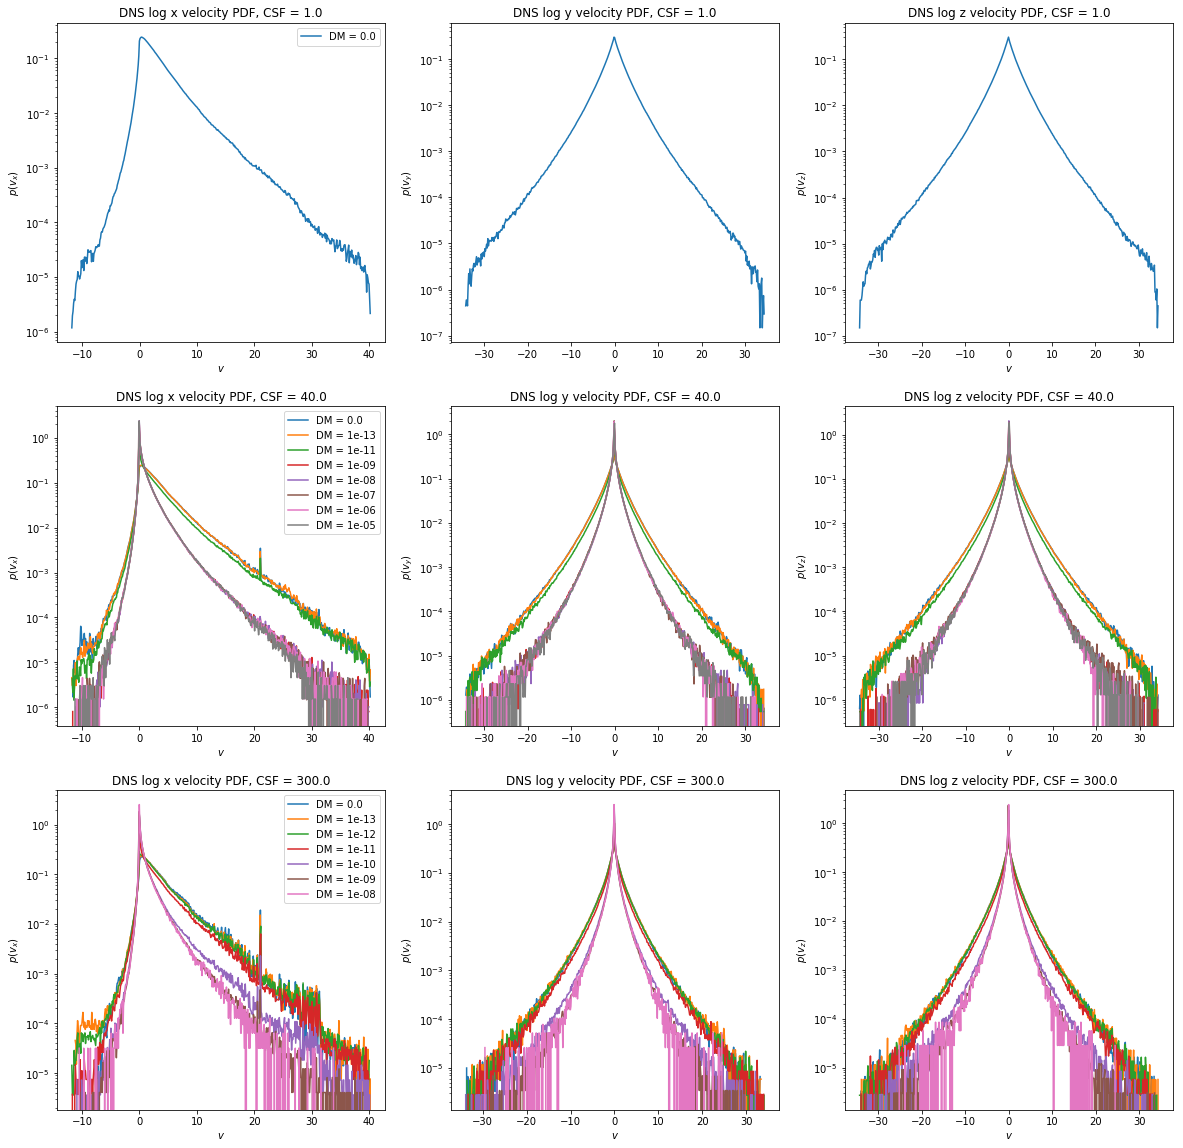

In [12]:
fig, axs = plt.subplots(3,3,figsize=(20,20))

m = 0
for P_K_ in [PLOT_KEYS_1, PLOT_KEYS_40, PLOT_KEYS_300] :
    (i,j) = (m,0)
    axs[i,j].set_title('DNS log x velocity PDF, CSF = ' + str(PARAM[P_K_[0]]['CSF']))
    for key in P_K_ : axs[i,j].semilogy(pvx_DNS[key][0], pvx_DNS[key][1],label = 'DM = ' + str(PARAM[key]['DM']))
    axs[i,j].legend();
    axs[i,j].set_xlabel(r'$v$');
    axs[i,j].set_ylabel(r'$p(v_x)$');

    (i,j) = (m,1)
    axs[i,j].set_title('DNS log y velocity PDF, CSF = ' + str(PARAM[P_K_[0]]['CSF']))
    for key in P_K_ : axs[i,j].semilogy(pvy_DNS[key][0], pvy_DNS[key][1],label = 'DM = ' + str(PARAM[key]['DM']))
    axs[i,j].set_xlabel(r'$v$');
    axs[i,j].set_ylabel(r'$p(v_y)$');

    (i,j) = (m,2)
    axs[i,j].set_title('DNS log z velocity PDF, CSF = ' + str(PARAM[P_K_[0]]['CSF']))
    for key in P_K_ : axs[i,j].semilogy(pvz_DNS[key][0], pvz_DNS[key][1],label = 'DM = ' + str(PARAM[key]['DM']))
    axs[i,j].set_xlabel(r'$v$');
    axs[i,j].set_ylabel(r'$p(v_z)$');
    m += 1
plt.savefig(DIR+'Figures/directional_speed_pdf'+extension)

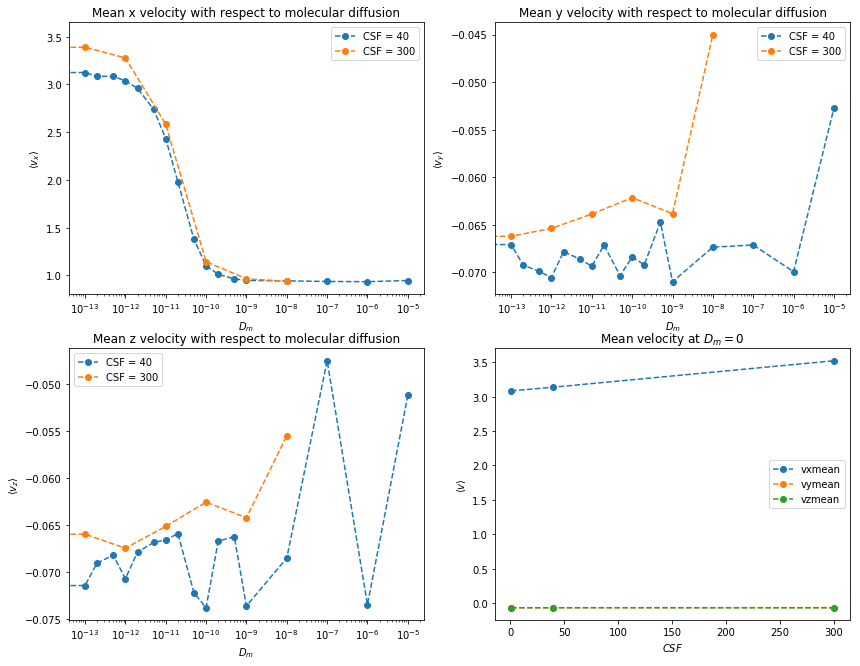

In [13]:
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(14,11))

ax = fig.add_subplot(gs[0, 0])
ax.set_title('Mean x velocity with respect to molecular diffusion')
ax.semilogx(D_VALUES_40,  vxmean[1:N_40+1],'o--', color = color_cycle[0], label = 'CSF = 40')
ax.semilogx(D_VALUES_300, vxmean[N_40+1:],'o--', color = color_cycle[1], label = 'CSF = 300')
ax.set_xlabel(r'$D_m$');
ax.set_ylabel(r'$\langle v_x \rangle$');
ax.legend()

ax = fig.add_subplot(gs[0, 1])
ax.set_title('Mean y velocity with respect to molecular diffusion')
ax.semilogx(D_VALUES_40,  vymean[1:N_40+1],'o--', color = color_cycle[0], label = 'CSF = 40')
ax.semilogx(D_VALUES_300, vymean[N_40+1:],'o--', color = color_cycle[1], label = 'CSF = 300')
ax.set_xlabel(r'$D_m$');
ax.set_ylabel(r'$\langle v_y \rangle$')
ax.legend()

ax = fig.add_subplot(gs[1, 0])
ax.set_title('Mean z velocity with respect to molecular diffusion')
ax.semilogx(D_VALUES_40,  vzmean[1:N_40+1],'o--', color = color_cycle[0], label = 'CSF = 40')
ax.semilogx(D_VALUES_300, vzmean[N_40+1:],'o--', color = color_cycle[1], label = 'CSF = 300')
ax.set_xlabel(r'$D_m$');
ax.set_ylabel(r'$\langle v_z \rangle$');
ax.legend()

ax = fig.add_subplot(gs[1, 1])
CSF_ = [1, 40, 300]
ax.set_title(r'Mean velocity at $D_m=0$')
ax.plot(CSF_,  [vxmean[0], vxmean[1], vxmean[N_40+1]],'o--', color = color_cycle[0], label = 'vxmean')
ax.plot(CSF_,  [vymean[0], vymean[1], vymean[N_40+1]],'o--', color = color_cycle[1], label = 'vymean')
ax.plot(CSF_,  [vzmean[0], vzmean[1], vzmean[N_40+1]],'o--', color = color_cycle[2], label = 'vzmean')
ax.set_xlabel(r'$CSF$');
ax.set_ylabel(r'$\langle v \rangle$');
ax.legend()
plt.savefig(DIR+'Figures/directional_speed_mean'+extension)

### Log velocity magnitude PDF

In [14]:
pdf_vDNS     = {} #Log velocity magnitude probability density function extracted directly from DNS
pdf_vDNS_fname = DIR+'Processed_data/pdf_vDNS.dat'
pdf_viso     = {} #to store isochronous histogram as a line
pdf_viso_fname = DIR+'Processed_data/pdf_viso.dat'
    
print('Loading vDNS pdf..')
pdf_vDNS = Load_pdf(pdf_vDNS_fname)
print('Loading viso pdf..')
pdf_viso = Load_pdf(pdf_viso_fname)

vmean_iso   = [] #Mean log velocity magnitude
vstd_iso    = [] #Standard deviation
vskew_iso   = [] #Skewness
vmean_DNS   = [] #Mean log velocity magnitude
vstd_DNS    = []
vskew_DNS   = [] #Skewness

for key in KEYS :
    vmean_iso.append(Return_mean(pdf_viso[key]))
    vstd_iso.append(Return_std(pdf_viso[key]))
    vskew_iso.append(Return_skew(pdf_viso[key]))
    vmean_DNS.append(Return_mean(pdf_vDNS[key]))
    vstd_DNS.append(Return_std(pdf_vDNS[key]))
    vskew_DNS.append(Return_skew(pdf_vDNS[key]))
print('Done.')

Loading vDNS pdf..
Loading viso pdf..
Done.


In [15]:
print(PARAM[key])

{'DM': 1e-08, 'SLSM': 0.0, 'TMAX': 100000000.0, 'CSF': 300.0}


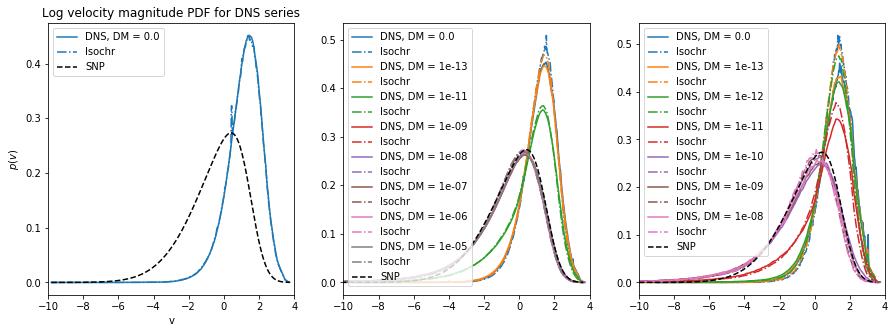

In [16]:
SET_XLIM = True

gs = gridspec.GridSpec(1, 3)
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(gs[0, 0])
ax.set_title('DNS log velocity magnitude PDF')
ax.set_title('Log velocity magnitude PDF for DNS series');
ax.set_xlabel('v')
ax.set_ylabel(r'$p(v)$')

m_ = 0
for key in PLOT_KEYS_1 : 
    ax.plot(pdf_vDNS[key][0],pdf_vDNS[key][1], label='DNS, DM = '+str(PARAM[key]['DM']), color = color_cycle[m_]);
    ax.plot(pdf_viso[key][0],pdf_viso[key][1], '-.', label='Isochr', color = color_cycle[m_]);
    m_ += 1

ax.plot(pdf_vDNS[key][0], p_skew(pdf_vDNS[key][0],Bentheimer1000), '--k', label = 'SNP');
ax.legend();
if SET_XLIM :
    ax.set_xlim([-10,4]);

ax = fig.add_subplot(gs[0, 1])
m_ = 0
for key in PLOT_KEYS_40 : 
    if m_ < len(color_cycle) : 
        ax.plot(pdf_vDNS[key][0],pdf_vDNS[key][1], label='DNS, DM = '+str(PARAM[key]['DM']), color = color_cycle[m_]);
        ax.plot(pdf_viso[key][0],pdf_viso[key][1], '-.', label='Isochr', color = color_cycle[m_]);
    m_ += 1

ax.plot(pdf_vDNS[key][0], p_skew(pdf_vDNS[key][0],Bentheimer1000), '--k', label = 'SNP');
ax.legend();
if SET_XLIM :
    ax.set_xlim([-10,4]);

ax = fig.add_subplot(gs[0, 2])
m_ = 0
for key in PLOT_KEYS_300 : 
    ax.plot(pdf_vDNS[key][0],pdf_vDNS[key][1], label='DNS, DM = '+str(PARAM[key]['DM']), color = color_cycle[m_]);
    ax.plot(pdf_viso[key][0],pdf_viso[key][1], '-.', label='Isochr', color = color_cycle[m_]);
    m_+= 1
ax.plot(pdf_vDNS[key][0], p_skew(pdf_vDNS[key][0],Bentheimer1000), '--k', label = 'SNP');
ax.legend();
if SET_XLIM :
    ax.set_xlim([-10,4]);

plt.savefig(DIR+'Figures/DNS_vs_iso_large_range'+extension)

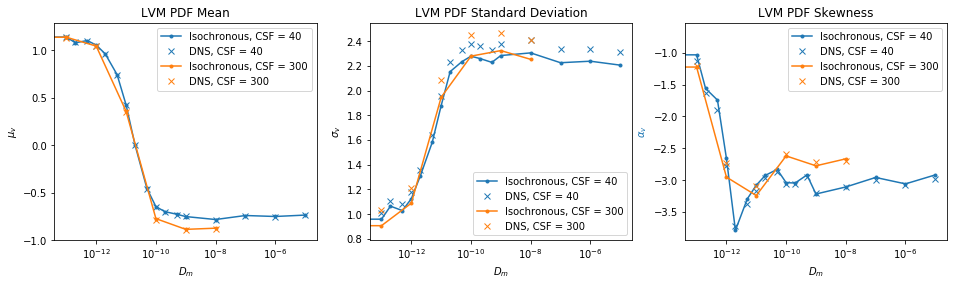

In [17]:
fig, axs = plt.subplots(1,3,figsize=(16,4))

ax = axs[0]
ax.set_title('LVM PDF Mean')
D_ = D_VALUES_40; VM_ = vmean_iso[1:N_40+1];
ax.semilogx(D_,VM_,'.-', color = color_cycle[0], label = 'Isochronous, CSF = 40')

D_ = D_VALUES_40; VM_ = vmean_DNS[1:N_40+1];
ax.semilogx(D_,VM_,'x',  color = color_cycle[0], label = 'DNS, CSF = 40')

D_ = D_VALUES_300; VM_ = vmean_iso[N_40+1:];
ax.semilogx(D_,VM_,'.-', color = color_cycle[1], label = 'Isochronous, CSF = 300')

D_ = D_VALUES_300; VM_ = vmean_DNS[N_40+1:];
ax.semilogx(D_,VM_,'x',  color = color_cycle[1], label = 'DNS, CSF = 300')

ax.set_xlabel(r'$D_m$');
ax.set_ylabel(r'$\mu_v$')
ax.legend();

ax = axs[1]
ax.set_title('LVM PDF Standard Deviation')
D_ = D_VALUES_40; VM_ = vstd_iso[1:N_40+1];
ax.semilogx(D_,VM_,'.-', color = color_cycle[0], label = 'Isochronous, CSF = 40')

D_ = D_VALUES_40; VM_ = vstd_DNS[1:N_40+1];
ax.semilogx(D_,VM_,'x',  color = color_cycle[0], label = 'DNS, CSF = 40')

D_ = D_VALUES_300; VM_ = vstd_iso[N_40+1:];
ax.semilogx(D_,VM_,'.-', color = color_cycle[1], label = 'Isochronous, CSF = 300')

D_ = D_VALUES_300; VM_ = vstd_DNS[N_40+1:];
ax.semilogx(D_,VM_,'x',  color = color_cycle[1], label = 'DNS, CSF = 300')
ax.set_xlabel(r'$D_m$');
ax.set_ylabel(r'$\sigma_v$')
ax.legend();

ax = axs[2]
ax.set_title('LVM PDF Skewness')
D_ = D_VALUES_40; VM_ = vskew_iso[1:N_40+1];
ax.semilogx(D_,VM_,'.-', color = color_cycle[0], label = 'Isochronous, CSF = 40')

D_ = D_VALUES_40; VM_ = vskew_DNS[1:N_40+1];
ax.semilogx(D_,VM_,'x',  color = color_cycle[0], label = 'DNS, CSF = 40')

D_ = D_VALUES_300; VM_ = vskew_iso[N_40+1:];
ax.semilogx(D_,VM_,'.-', color = color_cycle[1], label = 'Isochronous, CSF = 300')

D_ = D_VALUES_300; VM_ = vskew_DNS[N_40+1:];
ax.semilogx(D_,VM_,'x',  color = color_cycle[1], label = 'DNS, CSF = 300')
ax.set_xlabel(r'$D_m$');
ax.set_ylabel(r'$\alpha_v$', color = color_cycle[0])
ax.legend();

plt.savefig(DIR+'Figures/mean_v_to_dm'+extension)

#### Autocorrelation

We compute autocorrelation using the normalized estimator : 
$$ R(t_k= k dt) = \frac{1}{(N-k)\sigma^2}\sum_{t=0}^{N-k} (X_t-\mu)(X_{t+k}-\mu) $$

The cutting time $\tau_c$ that approach the distance between two closest uncorrelated measures is defined as the time where the tangent at $R(t_k=0)$ crosses the x-axis. 
This tangent is approximated as an $m$ points average slope as

$$ \partial R/\partial t|_{t_k=0} \approx \frac{R(t_m)-R(0)}{t_m - t_0} $$
leading to
$$ \tau_c = \frac{\Delta R}{\partial R/\partial t} \approx \frac{R(t_k=\tau_c)-R(t_k=0)}{(R(t_k=t_m) - R(t_k=0))/(t_m - t_0)}. $$

Per definition, $R(\tau_c)=0$ and $R(t_0=0)=1$ so the expression reduces to
$$ \tau_c = \frac{-t_m}{R(t_k=t_m)-1} $$

In [18]:
def autocorr_hm(x, Tmax, dt, Np, key) :
    mu    = np.mean(x)
    sigma = np.std(x)
    
    N     = len(x)
    Nk    = int(Tmax / dt)
    Nskip = max(1,Nk // Np)
    if Nskip == 1 : Np = min(Np,Nk)
    
    acf   = np.zeros(Np)
    trange= np.zeros(Np)
    i     = 0
    for i in range(Np):
        k = i*Nskip
        for t in range(0, N-k):
            acf[i] += 1.0/((N-k)*sigma**2)*(x[t]-mu)*(x[t+k]-mu)
        trange[i] = k*dt
    return (key, trange, acf) 

def parallel_autocorr(v_dict, Tmax = 0, Np = 50, Nmax = 1000, Nstart = 0) :
    v_autocorr = {}
    t_autocorr = {}
    results = Parallel(n_jobs=NCORES_MAX)(delayed(autocorr_hm)(v_dict[key][Nstart:Nstart+Nmax], Tmax, dt_iso[key][0], Np, key) for key in KEYS)
    for (key, t_, v_) in results :
        t_autocorr[key] = t_
        v_autocorr[key] = v_
    return (t_autocorr,v_autocorr)

def extract_cutting_time(x, acf, Np = 10) :
    tau = -x[Np]/(acf[Np]-1)
    return tau

In [22]:
Np   = 1000
Nmax = 40000
Tmax = 20
Nstart = 20000
v_autocorr = {}; vautocorrfname = DIR+'Processed_data/v_autocorr.dat'
t_autocorr = {}; tautocorrfname = DIR+'Processed_data/t_autocorr.dat'
if os.path.isfile(vautocorrfname) and (not True): 
    print('Loading autocorrelation functions..')
    v_autocorr = Load_data(vautocorrfname) 
    t_autocorr = Load_data(tautocorrfname)
else :
    v_iso = {}; dt_iso = {};
    print('Computing autocorrelation..')
    print('Loading processed data..')
    for CSF_ in CSF_VALUES :
        vname  = DIR+'Processed_data/v_iso_dt_fact_1.0_CSF'+CSF_+'.dat';
        toload = Load_data(vname)
        for key in toload : v_iso[key] = toload[key]
        dtname = DIR+'Processed_data/dt_iso_dt_fact_1.0_CSF'+CSF_+'.dat';
        toload = Load_data(dtname)
        for key in toload : dt_iso[key] = toload[key]
        toload = {}
    start = time.time()
    t_autocorr, v_autocorr = parallel_autocorr(v_iso, Tmax, Np, Nmax, Nstart)
    end   = time.time()
    print('\tTime needed : '+ str(end-start))
    print('Saving..')
    Save_data(v_autocorr, vautocorrfname)
    Save_data(t_autocorr, tautocorrfname)
    v_iso = {}; dt_iso = {};
print('Done.')

Computing autocorrelation..
Loading processed data..
	Time needed : 94.96809887886047
Saving..
Done.


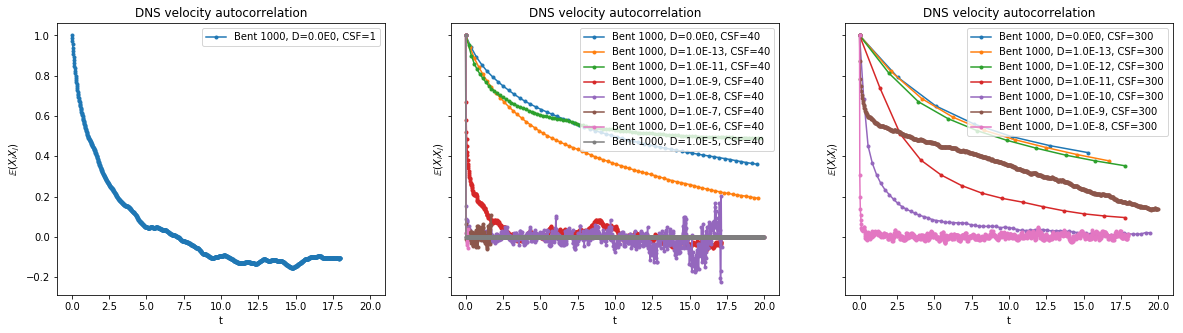

In [23]:
fig, axs = plt.subplots(1,3,figsize=(20,5), sharex = True, sharey = True)

ax = axs[0]
ax.set_title('DNS velocity autocorrelation')
for key in PLOT_KEYS_1 :
    ax.plot(t_autocorr[key], v_autocorr[key], '.-', label = key)
ax.set_xlabel('t')
ax.set_ylabel(r'$\mathbb{E}(X_i X_j)$')
ax.legend();

ax = axs[1]
ax.set_title('DNS velocity autocorrelation')
for key in PLOT_KEYS_40 :
    ax.plot(t_autocorr[key], v_autocorr[key], '.-', label = key)
ax.set_xlabel('t')
ax.set_ylabel(r'$\mathbb{E}(X_i X_j)$')
ax.legend();

ax = axs[2]
ax.set_title('DNS velocity autocorrelation')
for key in PLOT_KEYS_300 :
    ax.plot(t_autocorr[key], v_autocorr[key], '.-', label = key)
ax.set_xlabel('t')
ax.set_ylabel(r'$\mathbb{E}(X_i X_j)$')
ax.legend();

plt.savefig(DIR+'Figures/v_autocorr'+extension)

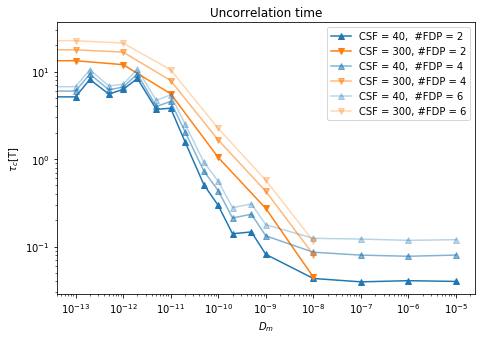

In [24]:
fig, ax = plt.subplots(1,1, figsize = (7.5,5.0))
ax.set_title('Uncorrelation time')
a_ = 1.0

for Np in [2, 4, 6] :
    cutting_times = [extract_cutting_time(t_autocorr[key], v_autocorr[key], Np) for key in KEYS]
    ax.plot(D_VALUES_40,  cutting_times[1:N_40+1],'^-', label = 'CSF = 40,  #FDP = '+ str(Np), color = color_cycle[0], alpha = a_)
    ax.plot(D_VALUES_300, cutting_times[N_40+1:],'v-', label = 'CSF = 300, #FDP = '+ str(Np), color = color_cycle[1], alpha = a_)
    a_ /= 1.8

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$D_m$')
ax.set_ylabel(r'$\tau_c$[T]')
ax.legend();
plt.savefig(DIR+'Figures/autocorr_time'+extension)

## Modelization of the previous PDF

Behavior of mean log velocity and std are similar to function of the form :

$$ f(y; a_1,a_2,b,c) = \frac{a_1 \exp{[-c(y-b)]} + a_2 \exp{[c(y-b)]}}{\exp{[-c(y-b)]} + \exp{[c(y-b)}]} $$

where $a_1$,$a_2$ are left and right asymptotic behavior, respectively, $b$ the inflexion point position, $c$ the growth rate .

It can be useful to transform $f(x; a_1,a_2,b,c)$ into
$$ f(x; a_1,a_2,B,c) = \frac{a_1 B x^{-c} +  a_2 x^{c}}{B x^{-c} + x^{c}} $$
where $ x = e^y$ and $B = e^{2bc}$

In [25]:
def f(x,a1,a2,B,c) :
    up   = a1 * B * x**(-c) + a2 * x**c
    down = B * x**(-c) + x**c
    return up/down

Parameters found : $ v_a = 8.7, \quad v_d = 6.8, \quad b = \ln 10^{-11} $

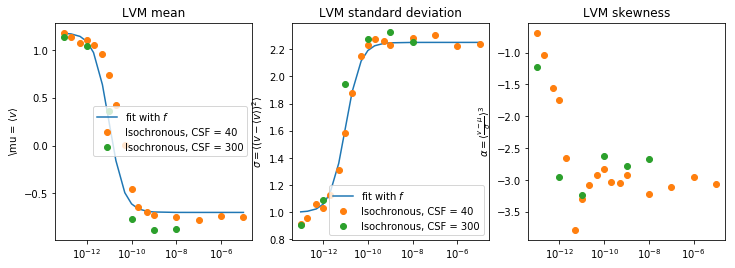

In [30]:
x = np.array([d_ for d_ in D_VALUES_40 if d_ > 0])
va = 1.18; vd = -0.7;
b = np.log(1.0e-11); c  = 0.65; 
B = np.exp(2*b*c)
fig, axs = plt.subplots(1,3,figsize=(12,4))
axs[0].set_title('LVM mean')
axs[0].semilogx(x,f(x,va,vd,B,c),'-', label=r'fit with $f$')
axs[0].semilogx(D_VALUES_40,vmean_iso[:N_40],'o', label='Isochronous, CSF = 40', color = color_cycle[1])
axs[0].semilogx(D_VALUES_300,vmean_iso[N_40+1:],'o', label='Isochronous, CSF = 300', color = color_cycle[2])
axs[0].set_ylabel(r'\mu = $\langle v \rangle$')
axs[0].legend();

sm = 1.0; sp = 2.25;
axs[1].set_title('LVM standard deviation')
axs[1].semilogx(x,f(x,sm,sp,B,c),'-', label=r'fit with $f$')
axs[1].semilogx(D_VALUES_40,vstd_iso[:N_40],'o', label='Isochronous, CSF = 40', color = color_cycle[1])
axs[1].semilogx(D_VALUES_300,vstd_iso[N_40+1:],'o', label='Isochronous, CSF = 300', color = color_cycle[2])
axs[1].set_ylabel(r'$\sigma = \langle (v - \langle v \rangle)^2 \rangle$')
axs[1].legend();

axs[2].set_title('LVM skewness')
axs[2].semilogx(D_VALUES_40,vskew_iso[:N_40],'o', label='Isochronous, CSF = 40', color = color_cycle[1])
axs[2].semilogx(D_VALUES_300,vskew_iso[N_40+1:],'o', label='Isochronous, CSF = 300', color = color_cycle[2])
#axs[2].semilogx(x,f(x,sm,sp,B,c),'^--', label=r'fit with $f$')
axs[2].set_ylabel(r'$\alpha = \langle\frac{v-\mu}{\sigma}\rangle^3$');

This behavior represent the variation of the mean of the skew normal pdf
$$ p(v; \mu, \sigma)=\frac{1}{\sqrt{2\pi}\sigma}\exp\left[-\frac{(v-\mu)^2}{2\sigma^2}\right](1-\textrm{erf}\left[-\frac{\alpha(v-\mu)}{\sqrt{2}\sigma}\right])$$
The mean, variance and skewness of skew normal pdf are given by 
$$\mu^* = \mu + \beta\sigma,\quad \sigma^* = \sigma \sqrt{ 1-\beta^2} \quad\textrm{and}\quad \alpha^* = \frac{4-\pi}{2}\frac{\beta^3}{(1-\beta^2)^{3/2}} \quad\textrm{with}\quad \beta := \sqrt{\frac{2}{\pi}}\frac{\alpha}{\sqrt{1+\alpha^2}}, $$
respectively

(Skewness defined as $\mathbb{E}\left[\left(\frac{X-\mu^*}{\sigma^*}\right)^3\right]$)

To fit our DNS pdf with skew normal pdf, the parameters $\mu,\sigma,\alpha$ must be set to reproduce the observed mean, variance and skewness of the data.
One can relate the skew normal pdf parameters $\mu,\sigma,\alpha$ to the mean, variance and skewness by inversing previous equations :
$$ \mu = \mu^* - \beta \sigma,\quad \sigma = \frac{\sigma^*}{\sqrt{1-\beta^2}} \quad\textrm{and}\quad \beta = \frac{\omega^*}{\sqrt{1+{\omega^*}^2}} \quad\textrm{with}\quad \omega^* :=\left(\frac{2}{4-\pi}\alpha^*\right)^{1/3}$$

The relation between the skewness $\alpha^*$ and our parameter $\alpha$ can be defined as :
$$  $$

In [31]:
def cbrt(x) :
    if x > 0 :
        return x**(1.0/3.0)
    else :
        return -((-x)**(1.0/3.0))

def beta_p(skew) :
    alpha = alpha_p(skew)
    return np.sqrt(2.0/np.pi)*alpha/np.sqrt(1+alpha**2)

def mu_p(avg, std, skew) :
    return avg - beta_p(skew) * std

def sigma_p(std, skew) :
    if beta_p(skew) < 1 :
        return std/np.sqrt(1-beta_p(skew))
    else :
        return std/np.sqrt(1+beta_p(skew))

def alpha_p(skew) :
    omega = cbrt(1.0*skew/(4.0-np.pi))
    if (1-2.0/np.pi)*omega**2 < 2.0/np.pi :
        return omega/np.sqrt(2.0/np.pi - (1-2.0/np.pi)*omega**2)
    else :
        return omega/np.sqrt(2.0/np.pi + (1-2.0/np.pi)*omega**2)
    
#Skew-normal PDF
def psk(v, avg, std, skew) :
    mu    = mu_p(avg, std, skew)
    sigma = sigma_p(std, skew)
    alpha = alpha_p(skew)
    return 1.0/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-(v-mu)**2/(2.0*sigma**2))*scsp.erfc(-alpha*(v-mu)/np.sqrt(2.0*sigma**2))

In [32]:
i = 0
v_stats = {}
for key in KEYS :
    tmp = {}
    tmp['avg']  = vmean_iso[i]
    tmp['std']  = vstd_iso[i]
    tmp['skew'] = vskew_iso[i]
    v_stats[key] = tmp
    i+= 1

In [33]:
def Extract_param (fname, param) :
    p_dict = {}
    for p_ in param :
        k  = 0
        for i in range(len(DIR),len(fname)) :
            if fname[i:i+len(p_)] == p_ :
                k = i+len(p_)
                break
        v_ = ''
        while (fname[k] != '_' and fname[k:k+2] != '.d') :
            v_ += fname[k]
            k  += 1
        p_dict[p_] = float(v_)
    return p_dict

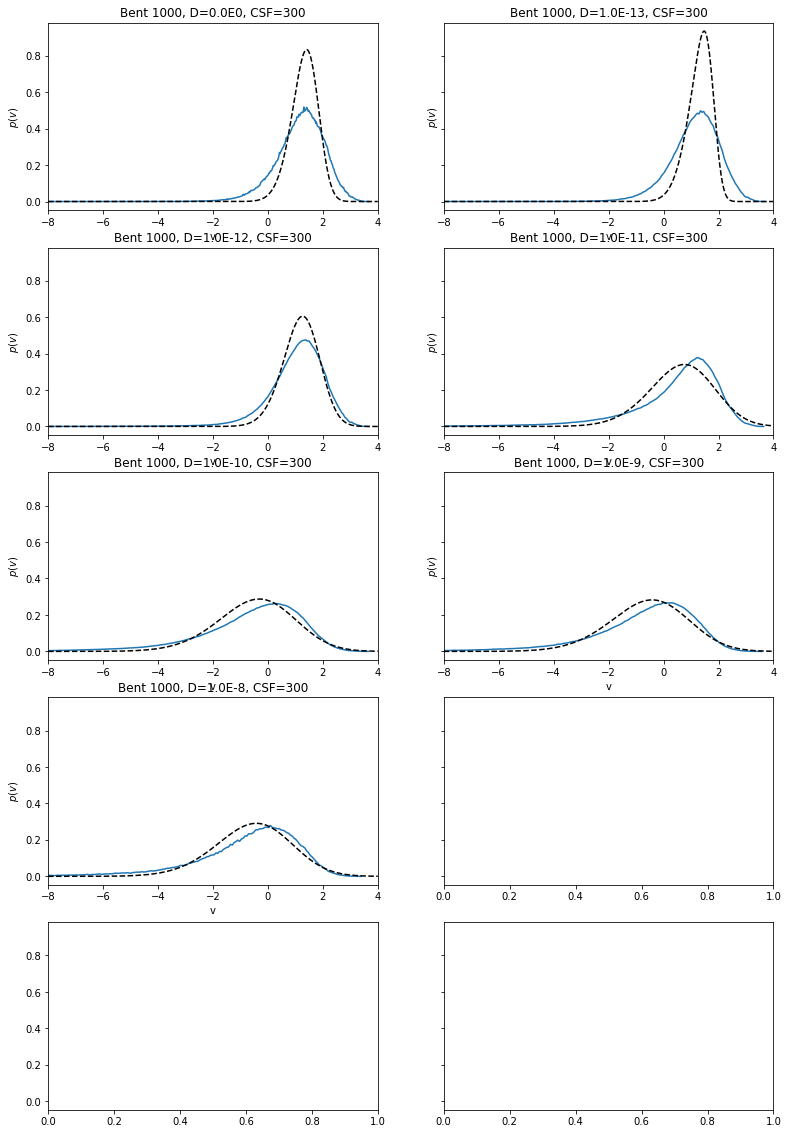

In [34]:
alpha = Bentheimer1000['alpha']
sigma = Bentheimer1000['sigma']
mu = Bentheimer1000['mu']
fig, axs = plt.subplots(5,2, figsize=(13,20), sharey=True);

V = np.linspace(-8,4,1000)
count    = 0
for key in PLOT_KEYS_300 :
    d_ = Extract_param(DATA[key],['DM'])
    (i,j) = (int(count/2),np.mod(count,2))
    ax    = axs[i,j]
    ax.set_title(key);
    ax.plot(pdf_viso[key][0], pdf_viso[key][1])
    avg = v_stats[key]['avg']; std = v_stats[key]['std']; skew = v_stats[key]['skew']
    ax.plot(V, psk(V, avg, std, skew), '--k', label = 'SNP for D = '+str(d_['DM']))
    ax.set_xlim([-8,4])
    ax.set_xlabel('v')
    ax.set_ylabel(r'$p(v)$')
    count += 1
    
plt.savefig(DIR+'Figures/DNS_vs_iso'+extension)

### Comparison with Markovian processes

In [35]:
samples = [Bentheimer1000]
Nmp = 100
MP_params = {
'seed': None,
'v0'  : 1.5,
'dt'  : 0.005,
'Tmax': 300.0,
'csf' : 1.0
}
MP_lvm  = {'params' : MP_params}
fname   = DIR+'Markov_processes/MP_lvm.dat'
rerun   = False
if (not os.path.isfile(fname)) or rerun:
    for sample in samples :
        MP_lvm[sample['name']]  = Parallel(n_jobs=NCORES_MAX)(
            delayed(LVM_process)
            (sample, MP_params) for i in range(Nmp))
        MP_lvm[sample['name']]=np.reshape(MP_lvm[sample['name']],len(MP_lvm[sample['name']][0])*Nmp)
        Save_data(MP_lvm,fname)
else :
    print('Loading data...')
    MP_lvm = Load_data(fname)
    print('Done')

Loading data...
Done


NameError: name 'PLOT_KEYS' is not defined

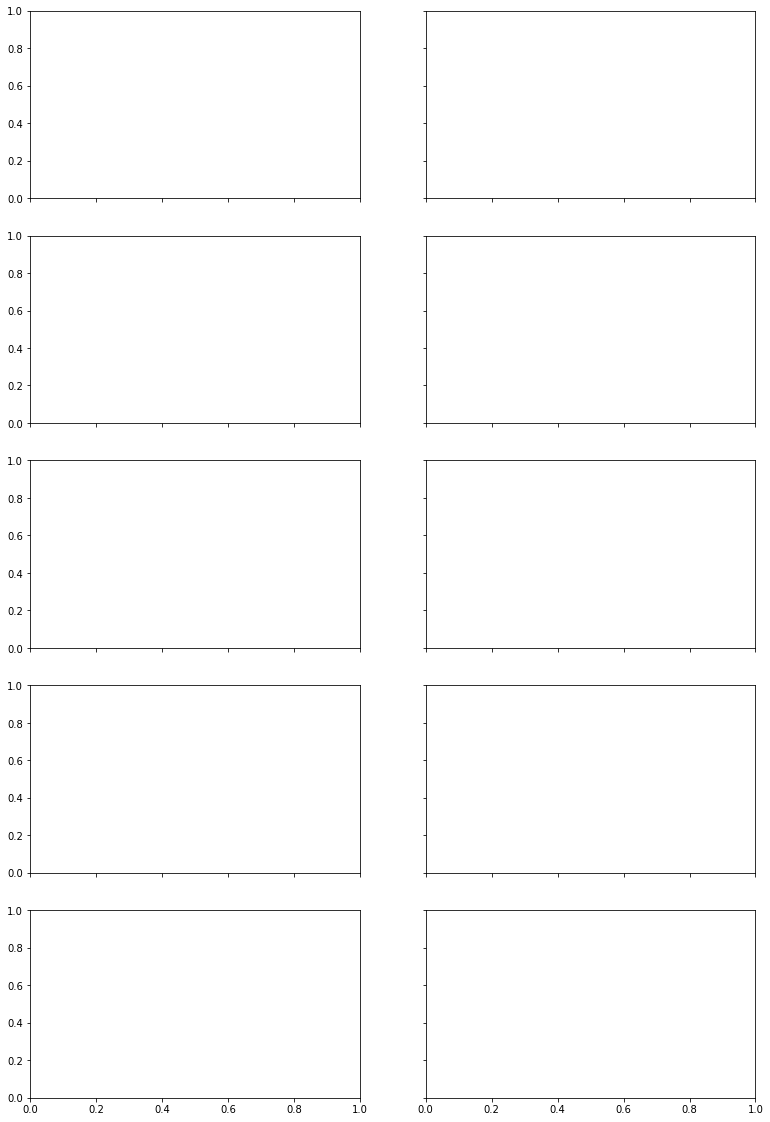

In [36]:
lvmpdf = Load_pdf(DIR+'Processed_data/bentheimer1000lvmpdf.dat')
fig, axs = plt.subplots(5,2,figsize=(13,20), sharex=True, sharey=True)
sample   = Bentheimer1000
vrange = np.linspace(-10,10,100)
count    = 0
for key in PLOT_KEYS :
    data1 = vDNS[key]
    data2 = v_iso[key]
    data3 = MP_lvm[sample['name']]
    (i,j) = (int(count/2),np.mod(count,2))
    axs[i,j].set_title('' + key)
    axs[i,j].hist(data1, bins = 200, label = key+' DNS',         density = True, alpha= 0.5)
    axs[i,j].hist(data2, bins = 200, label = key+' Isochronous', density = True, alpha= 0.5)
    axs[i,j].hist(data3, bins = 200, label = 'Markov process',   density = True, alpha= 0.5)
    axs[i,j].plot(vrange, p_skew(vrange,sample), label = 'SNP for Benth1000');
    axs[i,j].plot(lvmpdf['Bentheimer1000'][0], lvmpdf['Bentheimer1000'][1], '--k', label = 'Flow velocity distribution', alpha=0.7);
    axs[i,j].grid(True)
    axs[i,j].set_xlabel('v')
    axs[i,j].set_ylabel('p(v)')
    axs[i,j].legend()
    axs[i,j].set_xlim([-8,4])
    count += 1
del data1, data2, data3
plt.savefig(DIR+'Figures/summary'+extension)